# One-Zone Model Degeneracies

Exploring degeneracies between the star formation history (SFH) and Type Ia supernova delay time distribution (DTD) in abundance tracks and metallicity distribution functions (MDFs).

## Preamble

In [1]:
# General imports
from pathlib import Path
import math as m
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, ScalarFormatter
import vice

# VICE yields
from vice.yields.presets import JW20

# Plot settings
plt.rcParams.update({
    'xtick.direction': 'in',
    'xtick.top': True,
    'ytick.direction': 'in',
    'ytick.right': True,
    'figure.dpi': 140,
    'figure.figsize': (4, 4),
    'font.family': 'STIXgeneral',
    'mathtext.fontset': 'cm',
    'legend.fontsize': 8,
})

# File structure
output_dir = Path('../src/data/one_zone_outputs')

## Models

### Delay Time Distributions

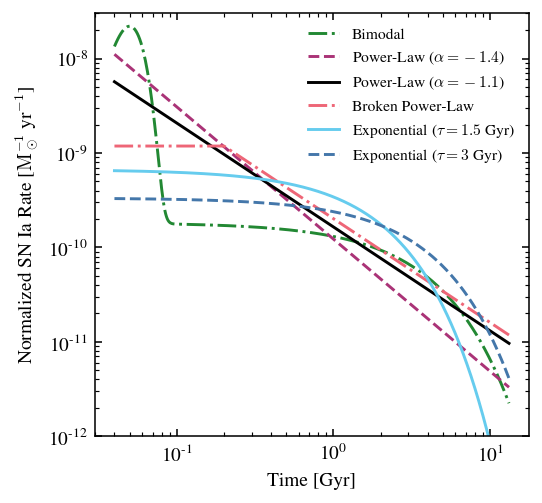

In [2]:
from dtd import PowerLaw, BrokenPowerLaw, Exponential, Bimodal

plaw = {
    'name': 'powerlaw',
    'func': PowerLaw(slope=-1.1),
    'label': r'Power-Law ($\alpha=-1.1$)',
    'color': 'k',
    'line': '-',
}
plaw_steep = {
    'name': 'powerlaw_steep',
    'func': PowerLaw(slope=-1.4),
    'label': r'Power-Law ($\alpha=-1.4$)',
    'color': '#aa3377',
    'line': '--',
}
plaw_broken = {
    'name': 'powerlaw_broken',
    'func': BrokenPowerLaw(),
    'label': 'Broken Power-Law',
    'color': '#ee6677',
    'line': '-.',
}
exp = {
    'name': 'exponential',
    'func': Exponential(timescale=1.5),
    'label': r'Exponential ($\tau=1.5$ Gyr)',
    'color': '#66ccee',
    'line': '-',
}
exp_long = {
    'name': 'exponential_long',
    'func': Exponential(timescale=3),
    'label': r'Exponential ($\tau=3$ Gyr)',
    'color': '#4477aa',
    'line': '--',
}
bimodal = {
    'name': 'bimodal',
    'func': Bimodal(),
    'label': 'Bimodal',
    'color': '#228833',
    'line': '-.',
}

dtds = [bimodal, plaw_steep, plaw, plaw_broken, exp, exp_long]

fig, ax = plt.subplots(figsize=(4, 4))
time = [0.001*i for i in range(40, 13201)]
for dtd in dtds:
    func = dtd['func']
    ax.plot(time, [func(t) for t in time], label=dtd['label'], c=dtd['color'], ls=dtd['line'])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((1e-12, 3e-8))
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel(r'Normalized SN Ia Rate [$\rm{M}_\odot^{-1}$ yr$^{-1}$]')
ax.legend(frameon=False)
plt.show()

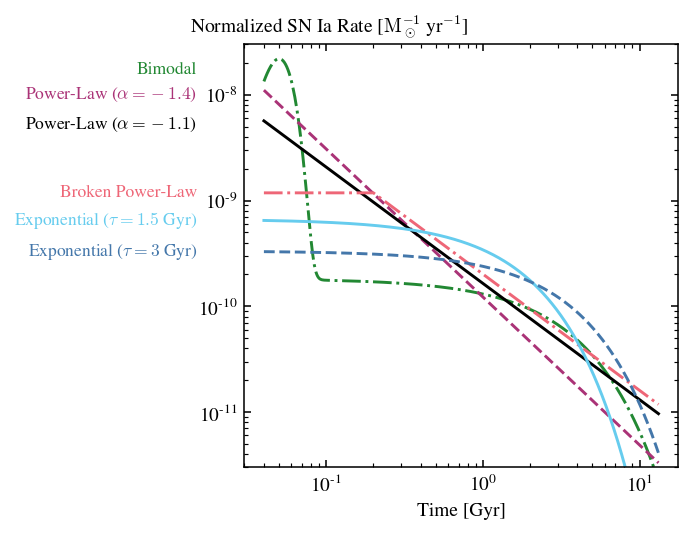

In [52]:
fig, ax = plt.subplots(figsize=(4, 4))
time = [0.001*i for i in range(40, 13201)]
for dtd in dtds:
    func = dtd['func']
    RIa = [func(t) for t in time]
    ax.plot(time, RIa, label=dtd['label'], c=dtd['color'], ls=dtd['line'])
    ax.text(0.015, RIa[3], dtd['label'], ha='right', va='center', color=dtd['color'], fontsize=9)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim((3e-3, None))
ax.set_ylim((3e-12, 3e-8))
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel(r'Normalized SN Ia Rate [$\rm{M}_\odot^{-1}$ yr$^{-1}$]', rotation=0, y=1.01, ha='left')
# ax.legend(frameon=False)
plt.show()

### Star Formation Histories

In [89]:
from ifr import BrokenExponential, Constant, InsideOut, LateBurst
from ifr import Exponential as ExponentialIFR
from sfe import Conroy2022, EfficiencyBurst, DoubleBurst

inside_out = {
    'name': 'insideout',
    'func': InsideOut(),
    'mode': 'ifr',
    'tau_star': 2,
    'label': 'Inside-Out',
    'color': 'k',
    'line': '-',
}
exp_ifr = {
    'name': 'exponential',
    'func': ExponentialIFR(),
    'mode': 'ifr',
    'tau_star': 2,
    'label': r'Exponential',
    'color': '#117733',
    'line': '--',
}
const = {
    'name': 'constant',
    'func': Constant(),
    'mode': 'ifr',
    'tau_star': 2,
    'label': 'Constant',
    'color': '#332288',
    'line': ':',
}
ifr_burst = {
    'name': 'lateburst',
    'func': LateBurst(),
    'mode': 'ifr',
    'tau_star': 2,
    'label': 'Late IFR Burst',
    'color': '#882255',
    'line': '-.',
}
sfe_burst = {
    'name': 'effburst',
    'func': InsideOut(),
    'mode': 'ifr',
    'tau_star': EfficiencyBurst(),
    'label': 'Late SFE Burst',
    'color': '#999933',
    'line': '--',
}
double_burst = {
    'name': 'doubleburst',
    'func': InsideOut(),
    'mode': 'ifr',
    'tau_star': DoubleBurst(),
    'label': 'Double SFE Burst',
    'color': '#aa4499',
    'line': '-.',
}
conroy22 = {
    'name': 'conroy22',
    'func': BrokenExponential(),
    'mode': 'ifr',
    'tau_star': Conroy2022(),
    'label': 'Conroy+ (2022) SFE',
    'color': '#44aa99',
    'line': ':',
}

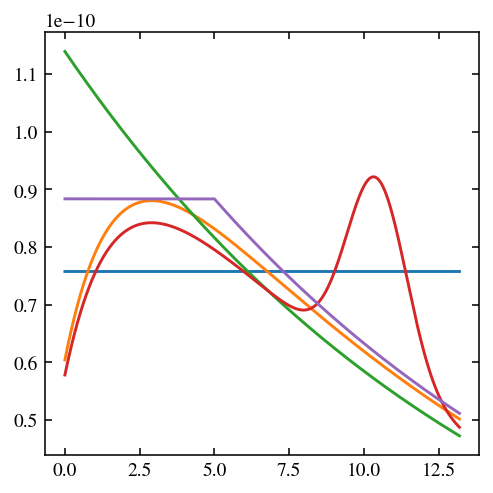

In [3]:
from ifr import BrokenExponential, Constant, InsideOut, Exponential, LateBurst

sfhs = [Constant(), InsideOut(), Exponential(15), LateBurst(), BrokenExponential()]

fig, ax = plt.subplots()
time = [0.001*i for i in range(13201)]
for sfh in sfhs:
    ax.plot(time, [sfh(t) for t in time])
plt.show()

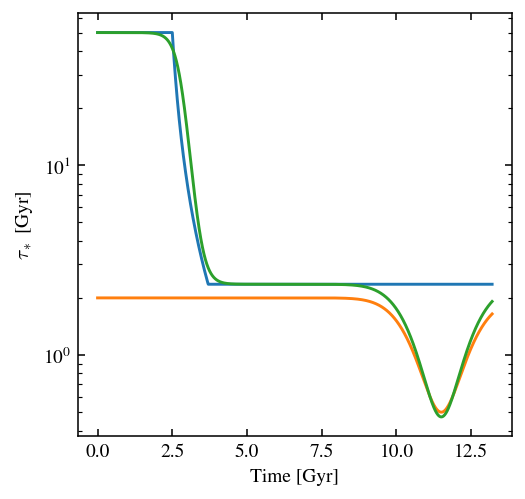

In [4]:
from sfe import Conroy2022, EfficiencyBurst, DoubleBurst

sfes = [Conroy2022(), EfficiencyBurst(), DoubleBurst(slope1=5, t1=2.8, amp2=0.8)]

fig, ax = plt.subplots()
for sfe in sfes:
    ax.plot(time, [sfe(t) for t in time])
ax.set_yscale('log')
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel(r'$\tau_*$ [Gyr]')
plt.show()

In [5]:
from ifr import BrokenExponential, Constant, InsideOut, LateBurst
from ifr import Exponential as ExponentialIFR
from sfe import Conroy2022, EfficiencyBurst, DoubleBurst

tmax = 13.2
dt = 0.005
simtime = np.arange(0, tmax+dt, dt) # Gyr
simtime_short = np.arange(0, 5+dt, dt)

params = dict(
    elements=('fe', 'o'),
    delay=0.04, # minimum Type Ia delay time in Gyr
    mode='ifr',
    dt=dt,
    eta=2.15,
    Mg0=0,
)

# Adjust Johnson+Weinberg 2020 yields
vice.yields.ccsne.settings['fe'] = 0.0014
vice.yields.ccsne.settings['o'] = 0.015
vice.yields.ccsne.settings['sr'] = 3.5e-8
vice.yields.sneia.settings['fe'] = 0.0017
vice.yields.sneia.settings['o'] = 0
vice.yields.sneia.settings['sr'] = 0

dtds = [plaw, plaw_steep, plaw_broken, exp, exp_long, bimodal]

for dtd in dtds:
    print(dtd)
    sz = vice.singlezone(name=str(output_dir / 'insideout' / dtd['name']), func=InsideOut(), tau_star=2, RIa=dtd['func'], **params)
    sz.run(simtime, overwrite=True)
    sz = vice.singlezone(name=str(output_dir / 'lateburst' / dtd['name']), func=LateBurst(), tau_star=2, RIa=dtd['func'], **params)
    sz.run(simtime, overwrite=True)
    sz = vice.singlezone(name=str(output_dir / 'exponential' / dtd['name']), func=ExponentialIFR(), tau_star=2, RIa=dtd['func'], **params)
    sz.run(simtime, overwrite=True)
    sz = vice.singlezone(name=str(output_dir / 'constant' / dtd['name']), func=Constant(), tau_star=2, RIa=dtd['func'], **params)
    sz.run(simtime, overwrite=True)
    sz = vice.singlezone(name=str(output_dir / 'effburst' / dtd['name']), func=InsideOut(), tau_star=EfficiencyBurst(), RIa=dtd['func'], **params)
    sz.run(simtime, overwrite=True)
    sz = vice.singlezone(name=str(output_dir / 'doubleburst' / dtd['name']), func=InsideOut(), tau_star=DoubleBurst(), RIa=dtd['func'], **params)
    sz.run(simtime, overwrite=True)

# Conroy+ 2022 yields
vice.yields.ccsne.settings['fe'] = 0.0012
vice.yields.ccsne.settings['mg'] = 0.0026
vice.yields.sneia.settings['fe'] = 0.003
params['elements'] = ('fe', 'mg')

for dtd in dtds:
    print(dtd)
    sz = vice.singlezone(name=str(output_dir / 'conroy22' / dtd['name']), func=BrokenExponential(), tau_star=Conroy2022(), RIa=dtd['func'], **params)
    sz.run(simtime, overwrite=True)
    sz = vice.singlezone(name=str(output_dir / 'conroyshort' / dtd['name']), func=Constant(), tau_star=Conroy2022(), RIa=dtd['func'], **params)
    sz.run(simtime_short, overwrite=True)

{'name': 'powerlaw', 'func': <dtd.PowerLaw object at 0x7f894fba9490>, 'label': 'Power-Law ($\\alpha=-1.1$)', 'color': 'k', 'line': '-'}
{'name': 'powerlaw_steep', 'func': <dtd.PowerLaw object at 0x7f894fba94f0>, 'label': 'Power-Law ($\\alpha=-1.4$)', 'color': '#aa3377', 'line': '--'}
{'name': 'powerlaw_broken', 'func': <dtd.BrokenPowerLaw object at 0x7f899405a940>, 'label': 'Broken Power-Law', 'color': '#ee6677', 'line': '-.'}
{'name': 'exponential', 'func': <dtd.Exponential object at 0x7f894fba9520>, 'label': 'Exponential ($\\tau=1.5$ Gyr)', 'color': '#66ccee', 'line': '-'}
{'name': 'exponential_long', 'func': <dtd.Exponential object at 0x7f894fbaed60>, 'label': 'Exponential ($\\tau=3$ Gyr)', 'color': '#4477aa', 'line': '--'}
{'name': 'bimodal', 'func': <dtd.Bimodal object at 0x7f894fbaec40>, 'label': 'Bimodal', 'color': '#228833', 'line': '-.'}
{'name': 'powerlaw', 'func': <dtd.PowerLaw object at 0x7f894fba9490>, 'label': 'Power-Law ($\\alpha=-1.1$)', 'color': 'k', 'line': '-'}
{'nam

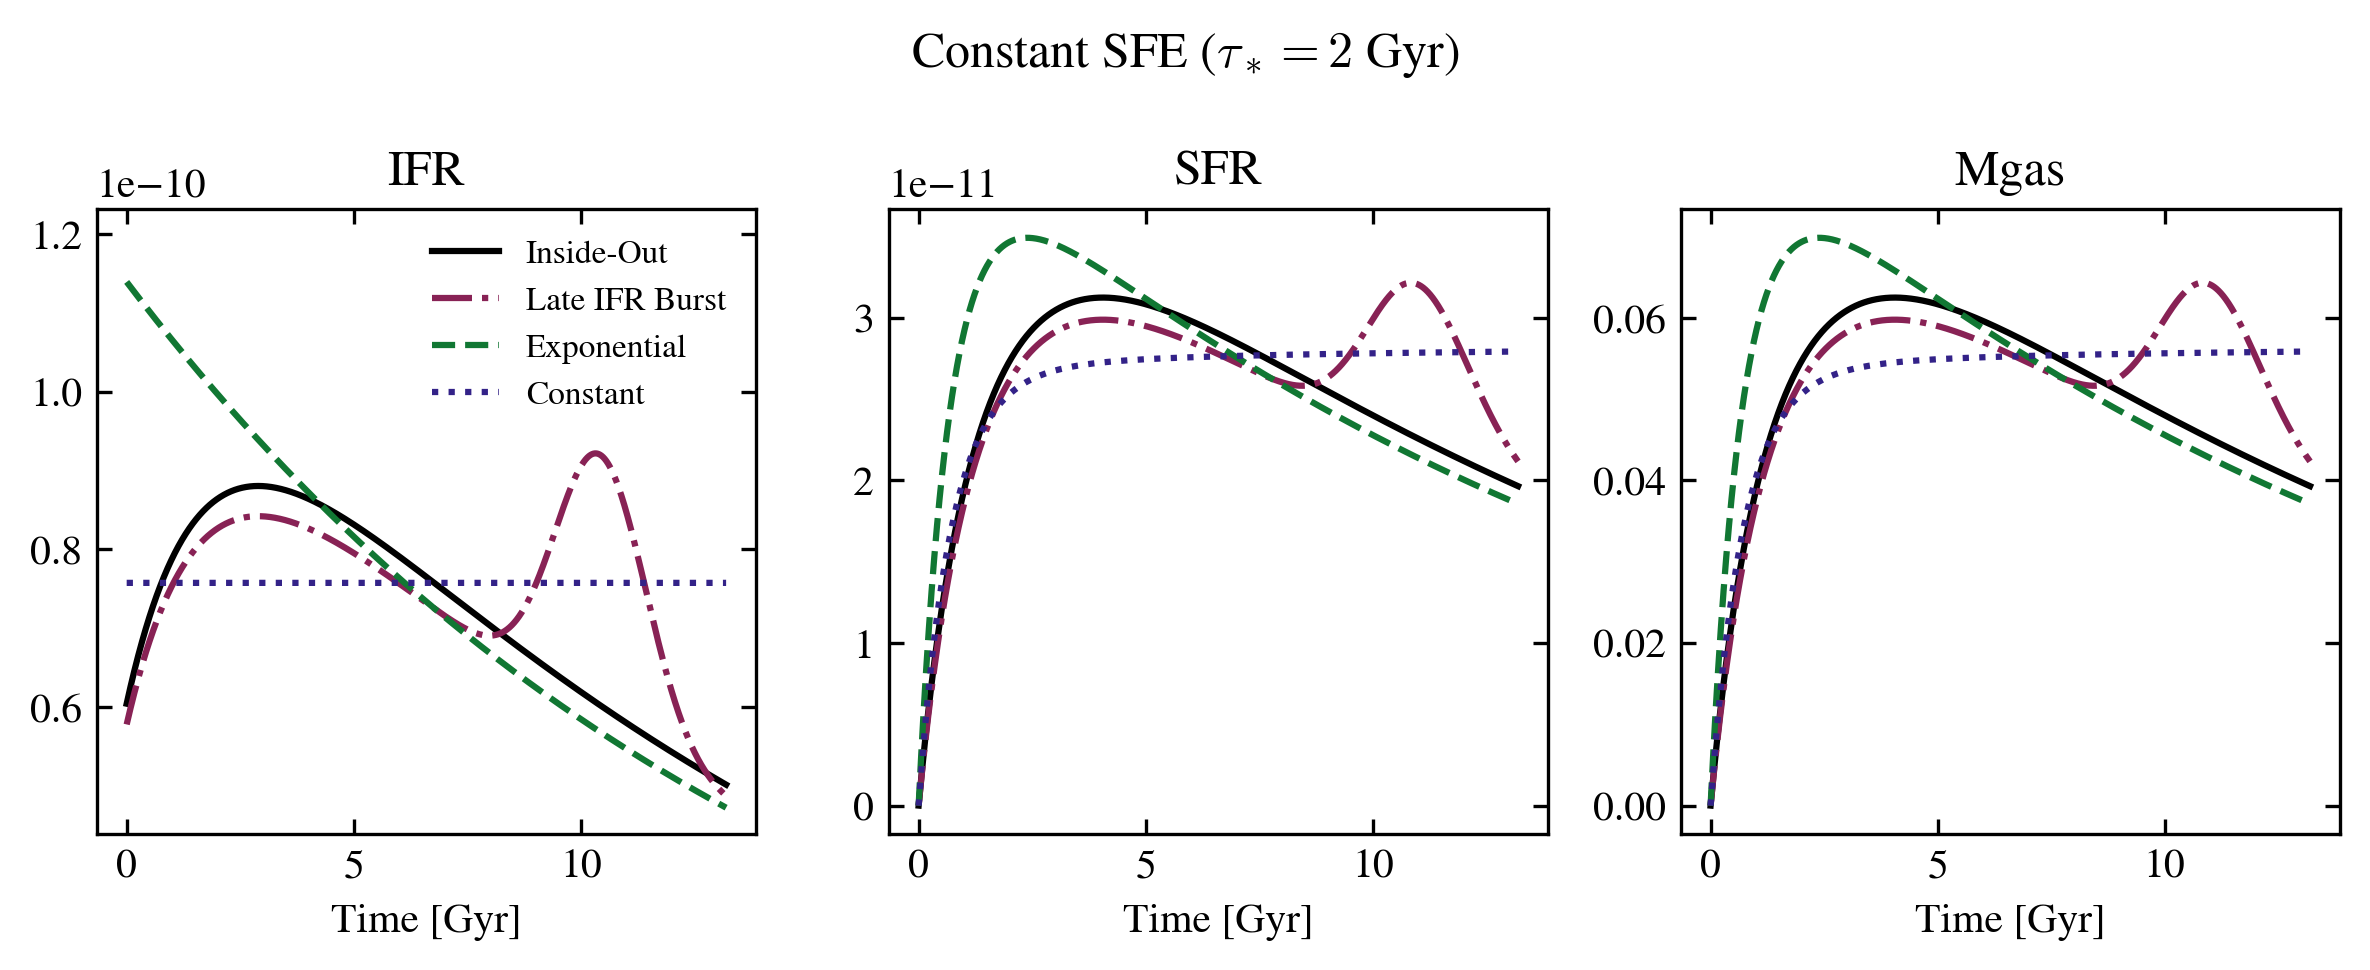

In [100]:
fig, axs = plt.subplots(1, 3, figsize=(8, 3.25), dpi=300, tight_layout=True)
runs = [inside_out, ifr_burst, exp_ifr, const]
dtd = 'powerlaw'
for run in runs:
    hist = vice.history(str(output_dir / run['name'] / dtd))
    t = hist['time']
    axs[0].plot(t, hist['ifr'], c=run['color'], ls=run['line'], label=run['label'])
    axs[1].plot(t, hist['sfr'], c=run['color'], ls=run['line'])
    axs[2].plot(t, hist['mgas'], c=run['color'], ls=run['line'])
axs[0].set_title('IFR')
axs[0].set_xlabel('Time [Gyr]')
axs[1].set_title('SFR')
axs[1].set_xlabel('Time [Gyr]')
axs[2].set_title('Mgas')
axs[2].set_xlabel('Time [Gyr]')
ylim0 = axs[0].get_ylim()
axs[0].set_ylim((ylim0[0], ylim0[1]*1.05))
axs[0].legend(frameon=False)
fig.suptitle(r'Constant SFE ($\tau_*=2$ Gyr)')
plt.show()

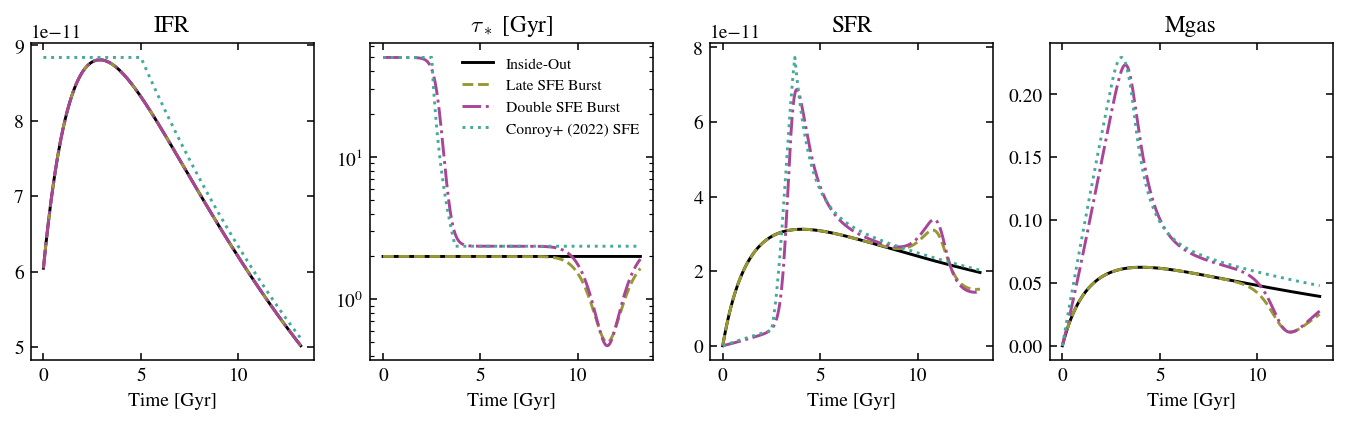

In [94]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
runs = [inside_out, sfe_burst, double_burst, conroy22]
dtd = 'powerlaw'
for run in runs:
    hist = vice.history(str(output_dir / run['name'] / dtd))
    t = hist['time']
    axs[0].plot(t, hist['ifr'], c=run['color'], ls=run['line'])
    axs[1].plot(t[1:], [hist['mgas'][i+1] / hist['sfr'][i+1] * 1e-9 for i in range(len(t)-1)], c=run['color'], ls=run['line'], label=run['label'])
    axs[2].plot(t, hist['sfr'], c=run['color'], ls=run['line'])
    axs[3].plot(t, hist['mgas'], c=run['color'], ls=run['line'])
axs[0].set_title('IFR')
axs[0].set_xlabel('Time [Gyr]')
axs[1].set_title(r'$\tau_*$ [Gyr]')
axs[1].set_yscale('log')
axs[1].set_xlabel('Time [Gyr]')
axs[2].set_title('SFR')
axs[2].set_xlabel('Time [Gyr]')
axs[3].set_title('Mgas')
axs[3].set_xlabel('Time [Gyr]')
axs[1].legend(frameon=False)
plt.show()

## Results

Plotting helper functions

In [57]:
def tri_track_axes(tlim=(-1, 14), felim=(-2, 0.5), olim=(-0.1, 0.45), alpha_tracer='O'):
    """Format triple-panel plot of metallicity and alpha abundance."""
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # First panel: metallicity vs time
    ax = axs[0]
    ax.set_xlim(tlim)
    ax.set_ylim(felim)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.set_xlabel('Time [Gyr]')
    ax.set_ylabel('[Fe/H]')

    # Second panel: alpha vs time
    ax = axs[1]
    ax.set_xlim(tlim)
    ax.set_ylim(olim)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.set_xlabel('Time [Gyr]')
    ax.set_ylabel('[' + alpha_tracer + '/Fe]')

    # Third panel: alpha vs fe
    ax = axs[2]
    ax.set_xlim(felim)
    ax.set_ylim(olim)
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[' + alpha_tracer + '/Fe]')
    
    return fig, axs

def plot_tracks(ax, sfh, dtd, ls='-', c=None, label=None, output_dir='../src/data/one_zone_outputs'):
    """
    Assumes a tri-panel setup per tri_tracks_axes()
    """
    history = vice.history(os.path.join(output_dir, sfh, dtd))
    axs[0].plot(history['time'], history['[fe/h]'], color=c, linestyle=ls, label=label)
    axs[1].plot(history['time'], history['[o/fe]'], color=c, linestyle=ls)
    axs[2].plot(history['[fe/h]'], history['[o/fe]'], color=c, linestyle=ls)
    

def tri_mdf_axes(felim1=(-2.5, 0.5), felim2=(-1, 0.25), ylim2=(1e-2, 20), olim=(-0.1, 0.45), logy=True, alpha_tracer='O'):
    """Format triple-panel plot of metallicity and oxygen distribution functions."""
    
    fig, axs = plt.subplots(1, 3, figsize=(12,4))

    # First panel: [Fe/H] distribution function
    ax = axs[0]
    ax.set_xlabel('[Fe/H]')
    ax.set_xlim(felim1)
    ax.set_ylabel('dN/d[Fe/H]')
    ax.set_yscale('log')
    
    # Second panel: zoom in near peak of first panel MDF
    ax = axs[1]
    ax.set_xlabel('[Fe/H]')
    ax.set_xlim(felim2)
    if logy:
        ax.set_yscale('log')
    ax.set_ylim(ylim2)
    ax.set_ylabel('dN/d[Fe/H]')
    
    # Third panel: [O/Fe] distribution function
    ax = axs[2]
    ax.set_xlabel('[%s/Fe]' % alpha_tracer)
    ax.set_xlim(olim)
    ax.set_ylabel('dN/d[%s/Fe]' % alpha_tracer)
    if logy:
        ax.set_yscale('log')

    return fig, axs

### Varying DTD

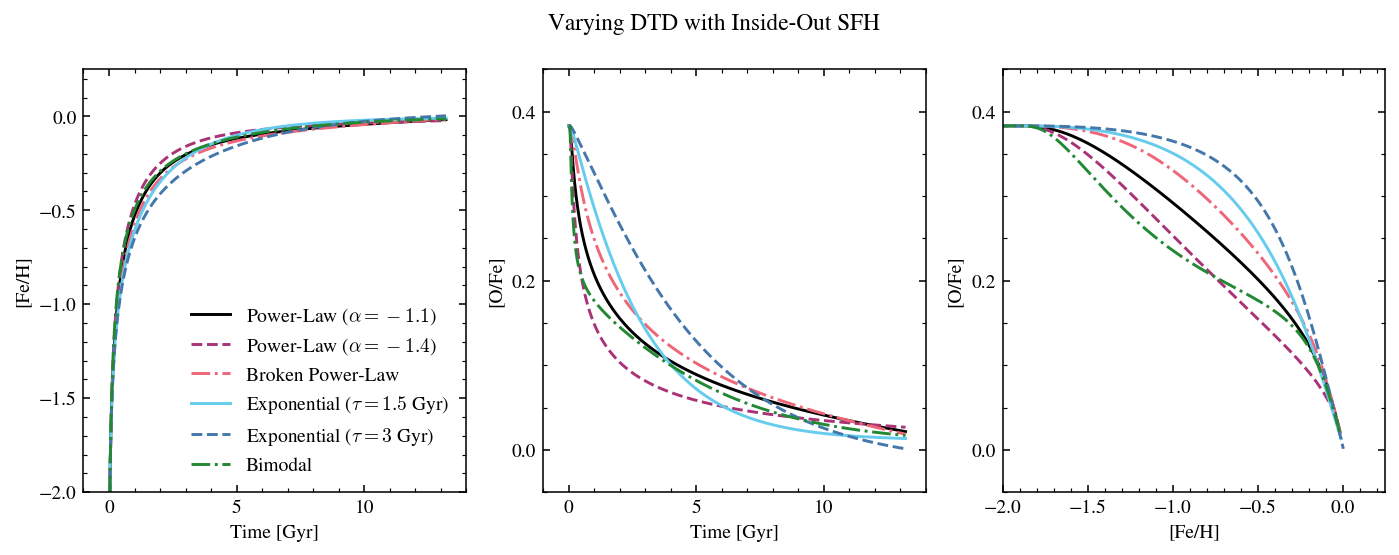

In [55]:
fig, axs = tri_track_axes(felim=(-2, 0.25), olim=(-0.05, 0.45))
sfh = 'insideout'
dtds = [plaw, plaw_steep, plaw_broken, exp, exp_long, bimodal]
for dtd in dtds:
    plot_tracks(ax, sfh, dtd['name'], c=dtd['color'], ls=dtd['line'], label=dtd['label'])
axs[0].legend(fontsize=10, frameon=False)
fig.suptitle('Varying DTD with Inside-Out SFH')
plt.show()

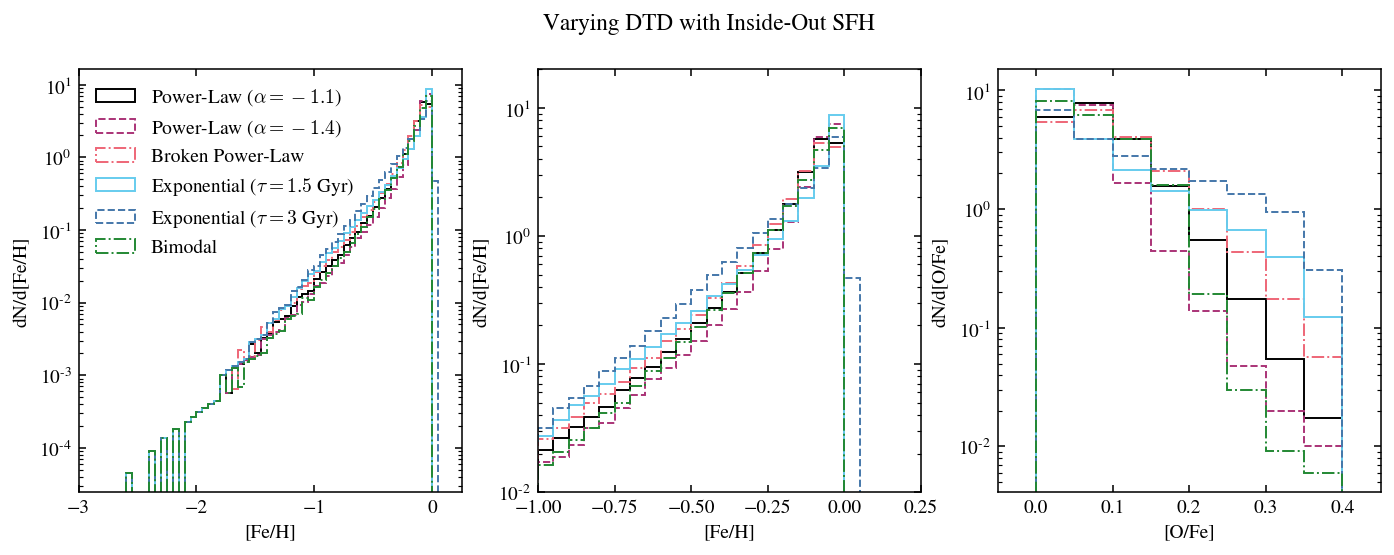

In [63]:
fig, axs = tri_mdf_axes(olim=(-0.05, 0.45), felim1=(-3, 0.25))
alpha_tracer = 'O'
sfh = 'insideout'
dtds = [plaw, plaw_steep, plaw_broken, exp, exp_long, bimodal]
for dtd in dtds:
    ls = dtd['line']
    c = dtd['color']
    label = dtd['label']
    mdf = vice.mdf(os.path.join('../src/data/one_zone_outputs', sfh, dtd['name']))
    bins = mdf['bin_edge_left'] + mdf['bin_edge_right'][-1:]
    axs[0].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls, label=label)
    axs[1].hist(bins[:-1], bins, weights=mdf['dn/d[fe/h]'], histtype='step', color=c, linestyle=ls)
    axs[2].hist(bins[:-1], bins, weights=mdf['dn/d[%s/fe]' % alpha_tracer.lower()], histtype='step', color=c, linestyle=ls)
    
axs[0].legend(fontsize=10, frameon=False, loc='upper left')
fig.suptitle('Varying DTD with Inside-Out SFH')
plt.show()

### Varying SFH

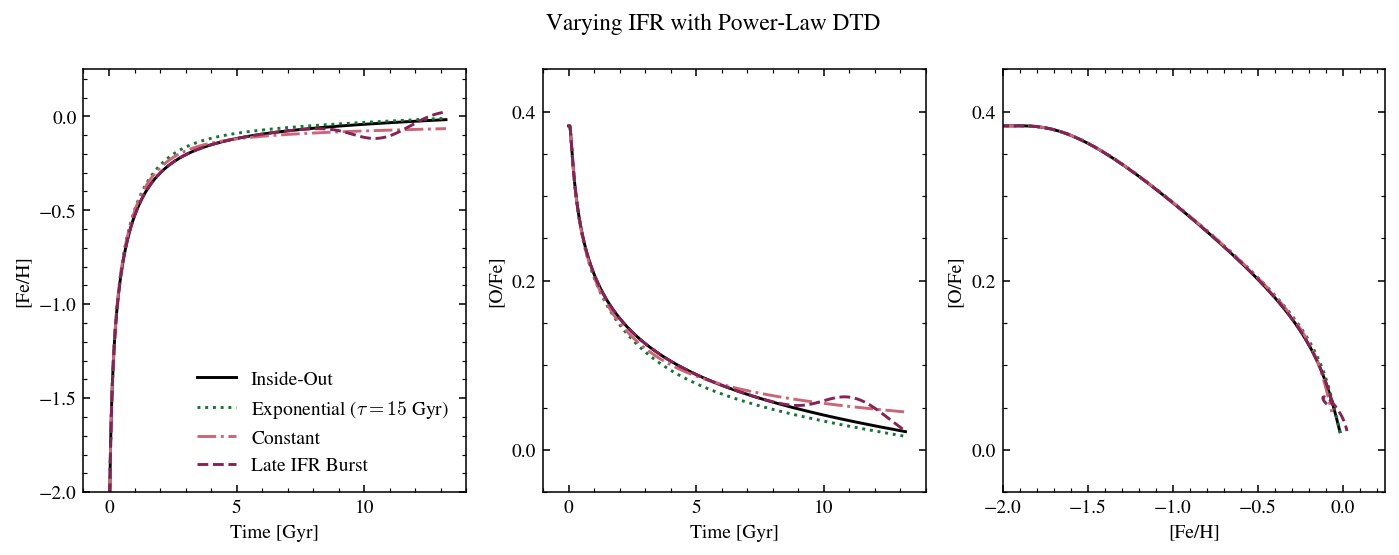

In [33]:
fig, axs = tri_track_axes(felim=(-2, 0.25), olim=(-0.05, 0.45))
sfhs = [inside_out, exp_ifr, const, ifr_burst]
dtd = 'powerlaw'
for sfh in sfhs:
    c = sfh['color']
    ls = sfh['line']
    history = vice.history(os.path.join('..', 'src', 'data', 'one_zone_outputs', sfh['name'], dtd))
    axs[0].plot(history['time'], history['[fe/h]'], color=c, linestyle=ls, label=sfh['label'])
    axs[1].plot(history['time'], history['[o/fe]'], color=c, linestyle=ls)
    axs[2].plot(history['[fe/h]'], history['[o/fe]'], color=c, linestyle=ls)
axs[0].legend(fontsize=10, frameon=False)
fig.suptitle('Varying IFR with Power-Law DTD')
plt.show()

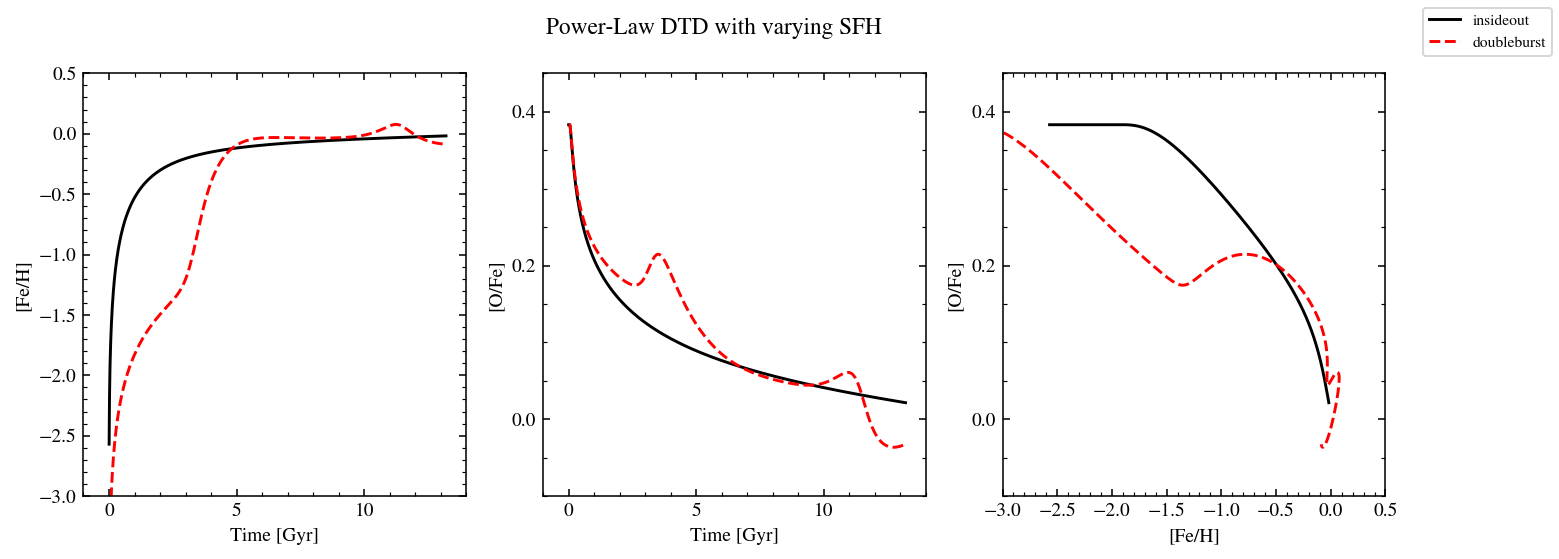

In [7]:
fig, axs = tri_track_axes(felim=(-3, 0.5))
sfhs = ['insideout', 'doubleburst']
dtds = ['powerlaw', 'powerlaw']
colors = ['k', 'r']
linestyles = ['-', '--']
for sfh, dtd, c, ls in zip(sfhs, dtds, colors, linestyles):
    history = vice.history(os.path.join('..', 'src', 'data', 'one_zone_outputs', sfh, dtd))
    axs[0].plot(history['time'], history['[fe/h]'], color=c, linestyle=ls, label=sfh)
    axs[1].plot(history['time'], history['[o/fe]'], color=c, linestyle=ls)
    axs[2].plot(history['[fe/h]'], history['[o/fe]'], color=c, linestyle=ls)
fig.legend()
fig.suptitle('Power-Law DTD with varying SFH')
plt.show()

## Discussion